In [3]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import functools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.layers import LSTM
from keras.utils import plot_model
from keras import backend as K
import keras.metrics
import tensorflow as tf


from keras.models import Sequential
from keras.layers import Dense, TimeDistributed
from keras.layers import LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca
from lob_data_utils.svm_calculation import lob_svm
from numpy.random import seed
seed(1)


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [4]:
data_length = 10000
stock = '9062'
gdf_filename_pattern = 'gdf_{}_' + 'len{}'.format(data_length) + '_r{}_s{}_K50'
gdf_parameters = [(1.0, 1.0), (0.1, 0.1), (0.1, 1.0), (1.0, 0.1), (0.01, 0.1)]

In [5]:
df_log = pd.read_csv('../gdf_pca/res_log_que.csv')   
df_log = df_log[df_log['stock'] == int(stock)]
columns = [c for c in df_log.columns if 'matthews' in c or 'roc_auc' in c]
df_log[columns]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc
17,0.068364,0.534164,0.10818,0.554053,0.071634,0.535742,0.065592,0.532787


In [6]:
def convert_scores_to_df(scores):
    scores2 = []
    for l in scores:
        res = {}
        for k, v in l.items():
            if isinstance(v, list):
                res[k] = np.mean(v)
            else:
                res[k] = v
        scores2.append(res)
    return pd.DataFrame(scores2)

In [7]:
def as_keras_metric(method):
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value

    return wrapper

auc_roc = as_keras_metric(tf.metrics.auc)

In [8]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, 
        gdf_filename_pattern=gdf_filename_pattern))

In [10]:
pca = gdf_dfs[0].get_pca('pca_gdf_que_prev10')

0.9927944224914231


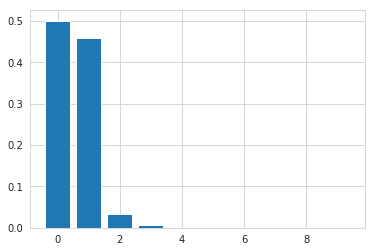

In [21]:
plt.bar(list(range(10)), pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_[0:3]))